#  Прогнозирование заказов такси

Компания «Такси+» собрала исторические данные о заказах такси. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Целевое значение метрики: RMSE < 48.

В ходе реализации проекта выполним следующие шаги:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Тестовую выборку сделаем размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тренд</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span><ul class="toc-item"><li><span><a href="#Создание-оптимальной-выборки" data-toc-modified-id="Создание-оптимальной-выборки-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Создание оптимальной выборки</a></span></li><li><span><a href="#Тестирование-модели-LinearRegression" data-toc-modified-id="Тестирование-модели-LinearRegression-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Тестирование модели LinearRegression</a></span></li></ul></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span><ul class="toc-item"><li><span><a href="#Создание-оптимальной-выборки" data-toc-modified-id="Создание-оптимальной-выборки-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Создание оптимальной выборки</a></span></li><li><span><a href="#Подбор-параметров-модели" data-toc-modified-id="Подбор-параметров-модели-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Подбор параметров модели</a></span></li><li><span><a href="#Тестирование-модели-CatBoostRegressor" data-toc-modified-id="Тестирование-модели-CatBoostRegressor-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Тестирование модели CatBoostRegressor</a></span></li></ul></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span><ul class="toc-item"><li><span><a href="#Создание-оптимальной-выборки" data-toc-modified-id="Создание-оптимальной-выборки-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Создание оптимальной выборки</a></span></li><li><span><a href="#Подбор-параметров-модели" data-toc-modified-id="Подбор-параметров-модели-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Подбор параметров модели</a></span></li><li><span><a href="#Тестирование-модели-LGBMRegressor" data-toc-modified-id="Тестирование-модели-LGBMRegressor-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Тестирование модели LGBMRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

Импортируем необходимые библиотеки и функции:

In [2]:
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

### Загрузка данных

Загрузим данные из файла /datasets/taxi.csv и выведем на экран основную информацию:

In [3]:
data = pd.read_csv('/datasets/taxi.csv')

In [4]:
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Датафрейм состоит из 26496 строк с данными о заказах такси и 2 столбцов, а именно:

- datetime — дата и время регистрации заказов (интервал 10 минут),

а также целевой признак:

- num_orders — количество заказов в интервале.

In [6]:
data['num_orders'].sort_values()

8535       0
13146      0
7960       0
6235       0
4502       0
        ... 
26315     95
25788     98
23775     99
23774    119
25789    119
Name: num_orders, Length: 26496, dtype: int64

**Вывод.** В датафрейме пропусков и некорректных значений нет. Количество заказов лежит в диапазоне от 0 до 462. Данные собраны за 6 месяцев: с 01.03.2018 по 31.08.2018.

Поскольку тип данных 'object' в столбце дата/время не подходит для дальнейшего выполнения проекта, прочитаем файл повторно, преобразовав столбец datetime к типу 'datetime' и преобразовав данный столбец в индексы датафрейма:

In [7]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [8]:
print(data.index.is_monotonic) # проверка того, что все даты идут в хронологическом порядке

True


Выполним ресемплирование по одному часу, сохраним датафрейм под именем data_original - будем его использовать в дальнейшей работе как первоначальный датафрейм:

In [9]:
data_original = data.resample('1H').sum()

Для текущих задач будем создавать копию оригинального датафрейма:

In [10]:
data = data_original.copy()

In [11]:
data # проверка

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

### Скользящее среднее

Для визуального анализа данных созададим датафрейм data_rolling_mean (в дальнейшем использоваться не будет) и в нём новый столбец 'rolling_mean' - скользящее среднее. Выведем на экран два графика: первоначальные данные, ресемплированные по одному часу, и скользящее среднее.

In [12]:
data_rolling_mean = data.copy()

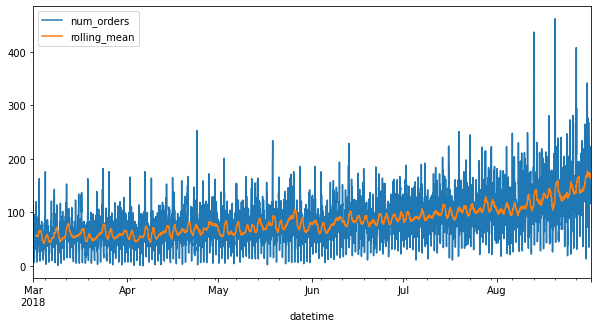

In [13]:
data_rolling_mean['rolling_mean'] = data_rolling_mean.rolling(24).mean()
plt.figure(figsize=(10, 5));
data_rolling_mean.plot(ax=plt.gca());

**Вывод.** На протяжении марта-августа 2018 года наблюдается плавное увеличение числа заказов. На основании имеющихся данных невозможно сказать, является ли этот тренд сезонным ростом, за которым последует спад, или наблюдается постоянная долговременная тенденция увеличения объёмов заказов компании.

### Сезонность

Произведем декомпозицию данных и разложим их на три компоненты: сезонность, тренд и остаток. Рассмотрим на графиках сезонность и тренд:

In [14]:
decomposed = seasonal_decompose(data)

Сезонность в начале рассматриваемого периода:

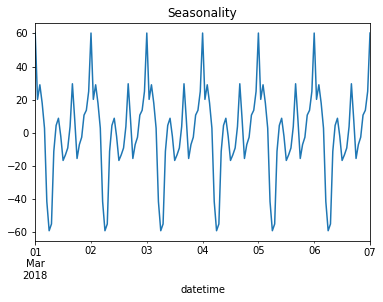

In [15]:
decomposed.seasonal['2018-03-01 00:00:00' : '2018-03-07 00:00:00'].plot()
plt.title('Seasonality');

Сезонность в конце рассматриваемого периода:

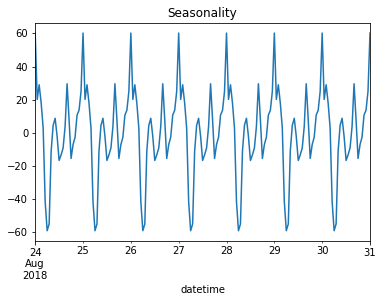

In [16]:
decomposed.seasonal['2018-08-24 00:00:00' : '2018-08-31 00:00:00'].plot()
plt.title('Seasonality');

**Вывод.** Графики сезонности в начале и в конце рассматриваемого периода идентичны - кратковременные тенденции сохраняются на протяжении 6 месяцев. Наблюдается ежедневная цикличность количества заказов.

Рассмотрим график сезонности на интервале двух суток:

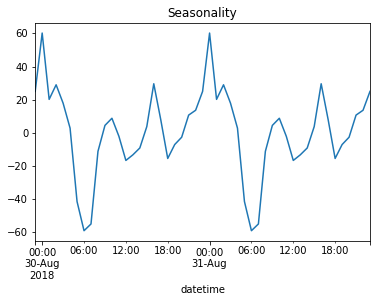

In [17]:
decomposed.seasonal['2018-08-29 23:00:00' : '2018-08-31 23:00:00'].plot()
plt.title('Seasonality');

**Вывод.** Наблюдается спад количества заказов в ночное время с минимумом около 06-00, затем рост, утренний час-пик (все едут на работу), спад, вечерний час-пик (все едут с работы), спад и рост числа заказов в вечернее время - время отдыха, семейных поездок в кино, магазины и т.п.

### Тренд

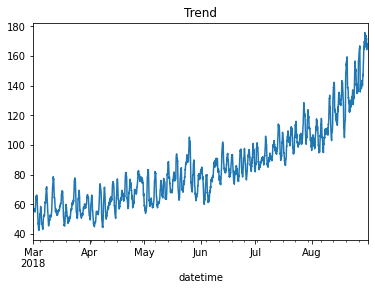

In [18]:
decomposed.trend.plot()
plt.title('Trend');

**Вывод.** График тренда в общем соответсвует тенденции, наблюдаемой на графике скользящего среднего - это постоянный рост количества заказов с марта по август.

## Обучение

В целях реализации проекта обучим и протестируем три модели:

- LinearRegression,
- CatBoostRegressor,
- LGBMRegressor

Каждую модель будем сразу же тестировать на тестовой подвыборке, в завершении проекта проведём сравнение результатов.

### Создание признаков

Для более оптимального обучения моделей создадим функцию make_features, создающую дополнительные признаки через через Отстающие значения (max_lag) и Скользящее среднее (rolling_mean_size), а также выделяющую в отдельные признаки день недели и час заказа. Столбцы "год", "месяц" и "день" создавать не будем - бесполезны для обучения.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

### LinearRegression

В качестве первой модели проведём эксперимент с линейной регрессией с параметрами по умолчанию.

Переберём в двух циклах значения max_lag и rolling_mean_size. Для каждой пары значений вызовем функцию make_features, т.е. создадим новую выборку. На каждом шаге двух циклов разобьём новую выборку на подвыборки train, valid и test в соотношении 80/10/10, обучим модель на train-выборке и получим предсказания на valid-выборке. Зафиксируем минимальное значение метрики RMSE и соответствующие ему значения max_lag и rolling_mean_size:

In [19]:
%%time
RMSE_best = 10000
for lag in range(1, 50):
    for size in range(1, 50):
        
        make_features(data, lag, size)
        
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train, shuffle=False, test_size=0.111111111)
        train = train.dropna()
        
        target_train = train['num_orders']
        features_train = train.drop('num_orders', axis=1)
        
        target_valid = valid['num_orders']
        features_valid = valid.drop('num_orders', axis=1)
        
        model = LinearRegression()
        model.fit(features_train, target_train)
        predict_valid_lr=model.predict(features_valid)
        
        RMSE_test_lr = mean_squared_error(target_valid, predict_valid_lr)**0.5
        if RMSE_test_lr < RMSE_best:
            RMSE_best = RMSE_test_lr
            lag_best = lag
            size_best = size
            model_best_lr = model

print('RMSE_best:', RMSE_best)
print('lag_best:', lag_best)
print('size_best:', size_best)

RMSE_best: 31.633487473769517
lag_best: 49
size_best: 20
CPU times: user 3min 41s, sys: 4min 2s, total: 7min 44s
Wall time: 7min 44s


#### Создание оптимальной выборки

На основании полученных оптимальных значений max_lag и rolling_mean_size создадим "оптимальную" выборку, чтобы обучить модель на train-подвыборке и проверить модель на test-подвыборке. Для этого вернёмся к первоначальному датафрейму data_original, создадим выборку с помощью функции make_features с оптимальными параметрами, разделим её на части train и test в соотношении 90/10 и создадим обучающие и целевые признаки:

In [66]:
lag_best=49
size_best=20
data = data_original.copy()
make_features(data, lag_best, size_best)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
        
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
        
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [35]:
features_test # проверка

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,152.866667
2018-08-13 15:00:00,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,147.333333
2018-08-13 16:00:00,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,148.333333
2018-08-13 17:00:00,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,139.733333
2018-08-13 18:00:00,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,120.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,156.133333
2018-08-31 20:00:00,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,147.333333
2018-08-31 21:00:00,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,152.400000


#### Тестирование модели LinearRegression

Обучим модель линейной регрессии на обучающей подвыборке, получим предсказания на тестовой подвыборке и посчитаем метрику RMSE:

In [67]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
predict_test_lr=model.predict(features_test)
        
RMSE_test_lr = mean_squared_error(target_test, predict_test_lr)**0.5

CPU times: user 119 ms, sys: 118 ms, total: 236 ms
Wall time: 142 ms


In [68]:
print('Значение метрики RMSE на тестовой выборке для модели LinearRegression:', RMSE_test_lr)

Значение метрики RMSE на тестовой выборке для модели LinearRegression: 41.853953365158674


**Вывод.** Значение метрики соответсвует предельному значению, заданному заказчиком (не более 48).

Рассмотрим на недельном графике качество предсказания модели.

In [60]:
predict_test_lr_series = pd.Series(predict_test_lr, index=target_test.index)

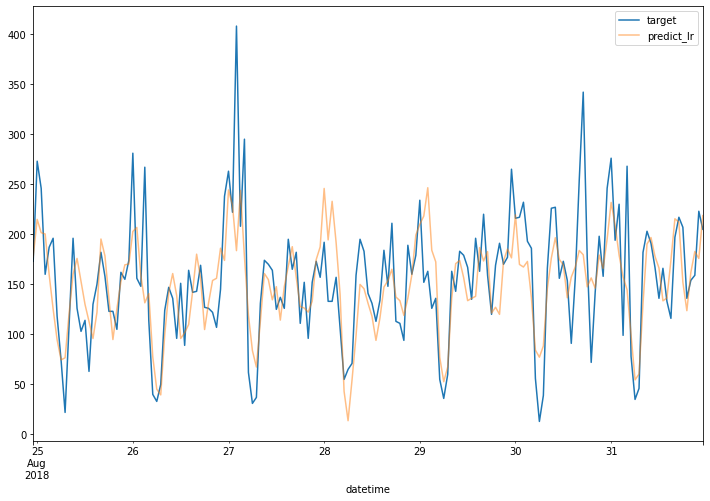

In [61]:
ax = target_test['2018-08-24 23:00:00': '2018-08-31 23:00:00'].plot(y='num_orders', figsize=(12, 8), label='target')
predict_test_lr_series['2018-08-24 23:00:00': '2018-08-31 23:00:00'].plot(figsize=(12, 8), label='predict_lr', ax=ax, alpha=0.5)
plt.legend()
plt.show()

**Вывод.** Модель лучше предсказывает утренние спады количества заказов, а нехарактерные максимумы (выбросы) предсказывает плохо. Для бизнес задач это плохо: при таком прогнозировании машин в часы-пик будет явно не хватать.

### CatBoostRegressor

Аналогично подберём оптимальные значения max_lag и rolling_mean_size для модели CatBoostRegressor. Сначала будем использовать параметры модели по умолчанию.

In [24]:
data = data_original.copy()

In [25]:
parameters_cb = {'random_state': 12345,
                 'verbose': 100}

In [26]:
%%time
RMSE_best = 10000
for lag in range(5, 55, 10):
    for size in range(5, 55, 10):
        print('lag=', lag, 'size=', size)
        make_features(data, lag, size)
        
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train, shuffle=False, test_size=0.111111111)
        train = train.dropna()
        
        target_train = train['num_orders']
        features_train = train.drop('num_orders', axis=1)
        
        target_valid = valid['num_orders']
        features_valid = valid.drop('num_orders', axis=1)
        
        model_cb = CatBoostRegressor(**parameters_cb)
        model_cb.fit(features_train, target_train, eval_set=(features_valid, target_valid))

lag= 5 size= 5
Learning rate set to 0.062064
0:	learn: 34.9093239	test: 57.2111425	best: 57.2111425 (0)	total: 49.3ms	remaining: 49.2s
100:	learn: 21.5294956	test: 36.8494952	best: 36.8494952 (100)	total: 240ms	remaining: 2.14s
200:	learn: 19.5708031	test: 35.0826391	best: 35.0826391 (200)	total: 450ms	remaining: 1.79s
300:	learn: 18.3512524	test: 34.9334058	best: 34.8840289 (271)	total: 640ms	remaining: 1.49s
400:	learn: 17.3263200	test: 34.7587464	best: 34.7456788 (397)	total: 823ms	remaining: 1.23s
500:	learn: 16.3664331	test: 34.6138815	best: 34.5903113 (479)	total: 1.01s	remaining: 1s
600:	learn: 15.5688509	test: 34.5018492	best: 34.4964729 (593)	total: 1.21s	remaining: 805ms
700:	learn: 14.9097004	test: 34.3607743	best: 34.3597605 (699)	total: 1.41s	remaining: 600ms
800:	learn: 14.2783098	test: 34.3533275	best: 34.3152162 (774)	total: 1.6s	remaining: 397ms
900:	learn: 13.6930359	test: 34.3048683	best: 34.3048683 (900)	total: 1.78s	remaining: 196ms
999:	learn: 13.1234166	test: 34.

**Вывод.** На основании информирования о промежуточных результатах работы модели можно сделать вывод, что качество модели незначительно меняется при изменении max_lag и rolling_mean_size. Чтобы не перегружать признаки и модель при обучении выберем значения max_lag=15 и rolling_mean_size=15, на которых наблюдается небольшое увеличение качества.

#### Создание оптимальной выборки

На основании выбранных значений max_lag и rolling_mean_size создадим "оптимальную" выборку, чтобы обучить модель на train-подвыборке и проверить модель на test-подвыборке. Для этого вернёмся к первоначальному датафрейму data_original, создадим выборку с помощью функции make_features, разделим её на части train и test в соотношении 90/10 и создадим обучающие и целевые признаки:

In [27]:
data = data_original.copy()
make_features(data, 15, 15)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
        
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

#### Подбор параметров модели

Для подбора параметров модели CatBoostRegressor воспользуемся методом grid_search(). Для этого создадим сетку параметров grid и сплиттер TimeSeriesSplit для корректного разбиения выборки в процессе кросс-валидации.

In [28]:
grid = {'iterations': [200, 400, 600],'learning_rate': [0.1, 0.15, 0.2],'depth': [2, 3, 4]}

In [29]:
model_cb = CatBoostRegressor()

In [30]:
cv_cb = TimeSeriesSplit(n_splits=8)

In [31]:
%%time
grid_search_result = model_cb.grid_search(grid,
                                          X=features_train,
                                          y=target_train,
                                          cv=cv_cb,
                                          shuffle=False,
                                          train_size=0.9)

0:	learn: 76.4248396	test: 111.9022942	best: 111.9022942 (0)	total: 1.44ms	remaining: 286ms
1:	learn: 70.2695121	test: 104.4300113	best: 104.4300113 (1)	total: 2.84ms	remaining: 281ms
2:	learn: 64.8070070	test: 97.8293637	best: 97.8293637 (2)	total: 3.85ms	remaining: 253ms
3:	learn: 60.1237107	test: 92.2488163	best: 92.2488163 (3)	total: 4.97ms	remaining: 243ms
4:	learn: 55.8870974	test: 86.8712496	best: 86.8712496 (4)	total: 5.95ms	remaining: 232ms
5:	learn: 52.2839106	test: 82.9087276	best: 82.9087276 (5)	total: 6.92ms	remaining: 224ms
6:	learn: 49.1506977	test: 79.3610081	best: 79.3610081 (6)	total: 7.9ms	remaining: 218ms
7:	learn: 46.2849667	test: 75.9669031	best: 75.9669031 (7)	total: 8.96ms	remaining: 215ms
8:	learn: 43.7557697	test: 72.7780762	best: 72.7780762 (8)	total: 9.94ms	remaining: 211ms
9:	learn: 41.7625432	test: 69.5658930	best: 69.5658930 (9)	total: 10.9ms	remaining: 207ms
10:	learn: 39.8230237	test: 66.7246822	best: 66.7246822 (10)	total: 11.8ms	remaining: 203ms
11:	l

In [32]:
best_params = grid_search_result['params']
print ('Оптимальное значение параметров модели:', best_params)

Оптимальное значение параметров модели: {'depth': 3, 'iterations': 400, 'learning_rate': 0.15}


#### Тестирование модели CatBoostRegressor

Для тесторования модели CatBoostRegressor создадим модель с лучшими параметрами best_params, полученными на предыдущем шаге, обучим её на обучающей выборке:

In [33]:
model_cb = CatBoostRegressor(**best_params)

In [34]:
%%time
model_cb.fit(features_train, target_train)

0:	learn: 36.9128808	total: 2.02ms	remaining: 807ms
1:	learn: 35.0486677	total: 3.88ms	remaining: 773ms
2:	learn: 33.9514531	total: 5.97ms	remaining: 790ms
3:	learn: 32.9509279	total: 7.91ms	remaining: 783ms
4:	learn: 31.8013125	total: 9.72ms	remaining: 768ms
5:	learn: 30.9933276	total: 11.6ms	remaining: 761ms
6:	learn: 30.3604963	total: 13.2ms	remaining: 743ms
7:	learn: 29.4650818	total: 15ms	remaining: 734ms
8:	learn: 28.8945400	total: 16.6ms	remaining: 719ms
9:	learn: 28.4671090	total: 18.4ms	remaining: 716ms
10:	learn: 28.0816078	total: 20.1ms	remaining: 712ms
11:	learn: 27.7801858	total: 22ms	remaining: 711ms
12:	learn: 27.5220641	total: 23.8ms	remaining: 708ms
13:	learn: 27.0802192	total: 25.5ms	remaining: 704ms
14:	learn: 26.8838870	total: 27.4ms	remaining: 703ms
15:	learn: 26.6094054	total: 29.2ms	remaining: 701ms
16:	learn: 26.2456644	total: 31.1ms	remaining: 700ms
17:	learn: 26.0036921	total: 32.6ms	remaining: 692ms
18:	learn: 25.8371531	total: 34.3ms	remaining: 687ms
19:	lea

Получим предсказания на тестовой подвыборке и посчитаем метрику RMSE:

In [35]:
%%time
predict_test_cb = model_cb.predict(features_test)
        
RMSE_test_cb = mean_squared_error(target_test, predict_test_cb)**0.5
print('Значение метрики RMSE на тестовой выборке для модели CatBoostRegressor:', RMSE_test_cb)

Значение метрики RMSE на тестовой выборке для модели CatBoostRegressor: 45.986625332733695
CPU times: user 4.99 ms, sys: 216 µs, total: 5.21 ms
Wall time: 3.38 ms


Рассмотрим на недельном графике качество предсказания модели.

In [56]:
predict_test_cb_series = pd.Series(predict_test_cb, index=target_test.index)

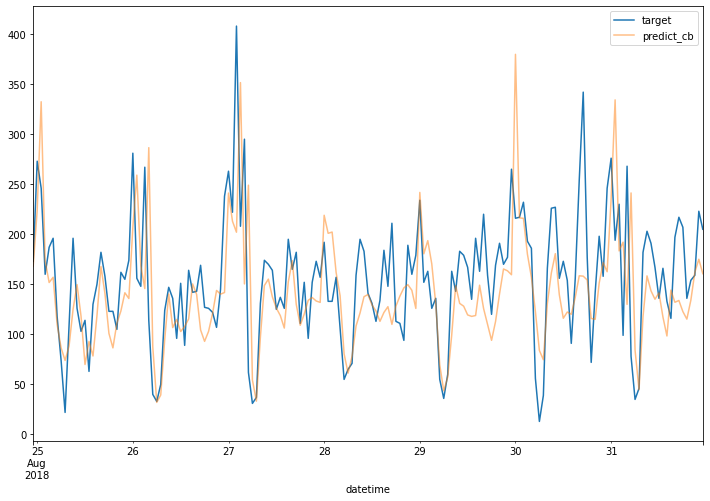

In [59]:
ax = target_test['2018-08-24 23:00:00': '2018-08-31 23:00:00'].plot(y='num_orders', figsize=(12, 8), label='target')
predict_test_cb_series['2018-08-24 23:00:00': '2018-08-31 23:00:00'].plot(figsize=(12, 8), label='predict_cb', ax=ax, alpha=0.5)
plt.legend()
plt.show()

**Вывод.** Модель хорошо предсказывает утренние спады количества заказов, а нехарактерные максимумы (выбросы) верно предсказывает далеко не всегда: иногда прогноз попадает верно, иногда происходит пропуск максимума, иногда прогноз оказывается выше фактического значения.

### LGBMRegressor

Аналогично подберём оптимальные значения max_lag и rolling_mean_size для модели LGBMRegressor.

In [36]:
data = data_original.copy()

In [37]:
parameters_lgbmr = {'random_state': 12345, 'metric': 'rmse'}

In [38]:
%%time
RMSE_best = 10000
for lag in range(1, 10):
    for size in range(1, 15):
        print('lag=', lag, 'size=', size)
        make_features(data, lag, size)
        
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train, shuffle=False, test_size=0.111111111)
        train = train.dropna()
        
        target_train = train['num_orders']
        features_train = train.drop('num_orders', axis=1)
        
        target_valid = valid['num_orders']
        features_valid = valid.drop('num_orders', axis=1)
        
        model_lgbmr = LGBMRegressor(**parameters_lgbmr)
        model_lgbmr.fit(features_train, target_train, eval_set=(features_valid, target_valid))

lag= 1 size= 1
[1]	valid_0's rmse: 56.2058
[2]	valid_0's rmse: 54.5007
[3]	valid_0's rmse: 52.9706
[4]	valid_0's rmse: 51.5669
[5]	valid_0's rmse: 50.3371
[6]	valid_0's rmse: 49.2435
[7]	valid_0's rmse: 48.3612
[8]	valid_0's rmse: 47.6104
[9]	valid_0's rmse: 46.8477
[10]	valid_0's rmse: 46.1397
[11]	valid_0's rmse: 45.634
[12]	valid_0's rmse: 45.0693
[13]	valid_0's rmse: 44.629
[14]	valid_0's rmse: 44.1792
[15]	valid_0's rmse: 43.716
[16]	valid_0's rmse: 43.3697
[17]	valid_0's rmse: 43.0874
[18]	valid_0's rmse: 42.7545
[19]	valid_0's rmse: 42.4712
[20]	valid_0's rmse: 42.2266
[21]	valid_0's rmse: 41.961
[22]	valid_0's rmse: 41.7483
[23]	valid_0's rmse: 41.6014
[24]	valid_0's rmse: 41.3907
[25]	valid_0's rmse: 41.2602
[26]	valid_0's rmse: 41.1343
[27]	valid_0's rmse: 41.0584
[28]	valid_0's rmse: 40.8529
[29]	valid_0's rmse: 40.7531
[30]	valid_0's rmse: 40.6102
[31]	valid_0's rmse: 40.5344
[32]	valid_0's rmse: 40.4724
[33]	valid_0's rmse: 40.3878
[34]	valid_0's rmse: 40.3086
[35]	valid_0

**Вывод.** На основании информирования о промежуточных результатах работы модели можно сделать вывод, что качество модели незначительно меняется при изменении max_lag и rolling_mean_size. Чтобы не перегружать признаки и модель при обучении выберем значения max_lag=9 и rolling_mean_size=14, на которых наблюдается небольшое увеличение качества.

#### Создание оптимальной выборки

На основании выбранных значений max_lag и rolling_mean_size создадим "оптимальную" выборку, чтобы обучить модель на train-подвыборке и проверить модель на test-подвыборке. Для этого вернёмся к первоначальному датафрейму data_original, создадим выборку с помощью функции make_features, разделим её на части train и test в соотношении 90/10 и создадим обучающие и целевые признаки:

In [39]:
data = data_original.copy()
make_features(data, 9, 14)
        
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
        
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

#### Подбор параметров модели

Для подбора параметров модели CatBoostRegressor воспользуемся функцией GridSearchCV. Для этого создадим словарь параметров parameters_GSCV_lgbmr со всеми значениями и сплиттер TimeSeriesSplit для корректного разбиения выборки в процессе кросс-валидации.

In [40]:
parameters_GSCV_lgbmr = {'num_leaves': [45, 50, 55],
                   'n_estimators': [700, 850, 1000],
                   'learning_rate': [0.05, 0.08, 0.11]}

In [41]:
model_lgbmr = LGBMRegressor(random_state=12345, metric='rmse')

In [42]:
cv_lgbmr = TimeSeriesSplit(n_splits=5)

In [43]:
%%time
optimized_model_lgbmr = GridSearchCV(model_lgbmr, parameters_GSCV_lgbmr, cv=cv_lgbmr)
optimized_model_lgbmr.fit(features_train, target_train)

CPU times: user 20min 12s, sys: 19.1 s, total: 20min 31s
Wall time: 20min 55s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(metric='rmse', random_state=12345),
             param_grid={'learning_rate': [0.05, 0.08, 0.11],
                         'n_estimators': [700, 850, 1000],
                         'num_leaves': [45, 50, 55]})

In [44]:
print ('Оптимальное значение параметров модели: {0}'. format (optimized_model_lgbmr.best_params_))

Оптимальное значение параметров модели: {'learning_rate': 0.05, 'n_estimators': 700, 'num_leaves': 45}


#### Тестирование модели LGBMRegressor

Для тесторования модели LGBMRegressor получим лучшую модель (best_estimator_), обучим её на обучающей выборке:

In [45]:
model_lgbmr_best = optimized_model_lgbmr.best_estimator_

In [46]:
model_lgbmr_best.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.05, metric='rmse', n_estimators=700,
              num_leaves=45, random_state=12345)

Получим предсказания на тестовой подвыборке и посчитаем метрику RMSE:

In [47]:
%%time
predict_test_lgbmr = model_lgbmr_best.predict(features_test)
        
RMSE_test_lgbmr = mean_squared_error(target_test, predict_test_lgbmr)**0.5
print('Значение метрики RMSE на тестовой выборке для модели LGBMRegressor:', RMSE_test_lgbmr)

Значение метрики RMSE на тестовой выборке для модели LGBMRegressor: 43.59631956282595
CPU times: user 88.4 ms, sys: 0 ns, total: 88.4 ms
Wall time: 91.1 ms


Рассмотрим на недельном графике качество предсказания модели.

In [49]:
predict_test_lgbmr_series = pd.Series(predict_test_lgbmr, index=target_test.index)

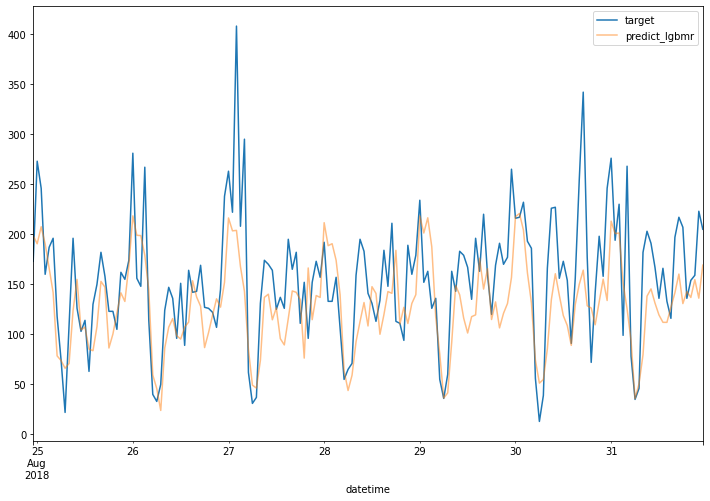

In [55]:
ax = target_test['2018-08-24 23:00:00': '2018-08-31 23:00:00'].plot(y='num_orders', figsize=(12, 8), label='target')
predict_test_lgbmr_series['2018-08-24 23:00:00': '2018-08-31 23:00:00'].plot(figsize=(12, 8), label='predict_lgbmr', ax=ax, alpha=0.5)
plt.legend()
plt.show()

**Вывод.** Модель хорошо предсказывает утренние спады количества заказов, а нехарактерные максимумы (выбросы) предсказывает плохо. Для бизнес задач это плохо: при таком прогнозировании машин в часы-пик будет явно не хватать.

## Сравнение моделей

Подведём итоги и сведём результаты в единую таблицу:

In [51]:
results = pd.DataFrame({'Модель': ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor'],
                      'RMSE': [RMSE_test_lr, RMSE_test_cb, RMSE_test_lgbmr],
                       'Время подбора параметров, сек': [0, 26, 1260],
                       'Скорость предсказания, мс': [107.0, 5.2, 91]}, index=[1, 2, 3])

In [52]:
results

,Модель,RMSE,"Время подбора параметров, сек","Скорость предсказания, мс"
1,LinearRegression,41.859136,0,107.0
2,CatBoostRegressor,45.986625,32,5.2
3,LGBMRegressor,43.596320,1740,176.0


## Общий вывод

В ходе реализации проекта по построению модели для прогнозирования количества заказов такси на следующий час были обучены и изучены для сравнения качества три модели: LinearRegression, CatBoostRegressor и LGBMRegressor.

Все три модели показали близкие значения метрики качества RMSE, в диапазоне 42-46.

С точки зрения времени подбора гиперпараметров лучше всего себя проявила линейная регрессия, показав приемлемое качество с параметрами по умолчанию.  
Модель CatBoostRegressor с методом grid_search() подобрала оптимальные параметры (сетка 3х3 и 5 циклов кросс-валидации) достаточно быстро - за 32 секунды.  
Хуже всего показала себя модель LGBMRegressor с функцией GridSearchCV: на ту же сетку параметров 3х3 с 5 циклами кросс-валидации ей понадобилось 21 минута.

Принимая во внимание то, что скорость предсказания у CatBoostRegressor в 20 раз выше, чем у LinearRegression, можно рекомендовать заказчику использовать CatBoostRegressor для его бизнес-задач.